In [1]:
!pip install datasets

In [27]:
torch.cuda.manual_seed_all(423)

In [1]:
from datasets import load_dataset

dataset = load_dataset("imdb")
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [9]:
from transformers import DistilBertForSequenceClassification, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized = dataset.map(tokenize_fn, batched=True)
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [14]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch

def collate_fn(batch):
    # Each batch item is a dict: {'input_ids': ..., 'attention_mask': ..., 'label': ...}
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch])

    # Pad to max length *within this batch*
    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    padded_attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    return {
        "input_ids": padded_input_ids,
        "attention_mask": padded_attention_masks,
        "labels": labels
    }


train_loader = DataLoader(tokenized["train"], batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(tokenized["test"], batch_size = 16, collate_fn=collate_fn)

## C1

In [26]:
from tqdm import tqdm
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 5

train_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
  model.train()
  total_loss = 0
  total_correct = 0
  total_samples = 0
  for batch in tqdm(train_loader):
      optimizer.zero_grad()

      inputs = {
          "input_ids": batch["input_ids"].to(device),
          "attention_mask": batch["attention_mask"].to(device),
          "labels": batch["labels"].to(device),
      }

      outputs = model(**inputs)
      loss = outputs.loss
      loss.backward()
      optimizer.step()

      logits = outputs.logits
      preds = torch.argmax(logits, dim = 1)
      labels = batch["labels"].to(device)
      correct = (preds == labels).sum().item()
      total_correct += correct
      total_samples += len(labels)
      total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  avg_accuracy = total_correct / total_samples
  train_loss.append(avg_loss)
  train_accuracy.append(avg_accuracy)

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for batch in test_loader:
          inputs = {
              "input_ids": batch["input_ids"].to(device),
              "attention_mask": batch["attention_mask"].to(device),
          }
          labels = batch["labels"].to(device)

          logits = model(**inputs).logits
          preds = torch.argmax(logits, dim=1)

          correct += (preds == labels).sum().item()
          total += labels.size(0)

  accuracy = correct / total
  test_accuracy.append(accuracy)

  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}")


100%|██████████| 1563/1563 [02:03<00:00, 12.66it/s]


Epoch 1/5, Loss: 0.0317, Train Accuracy: 0.9902, Test Accuracy: 0.8764


100%|██████████| 1563/1563 [02:03<00:00, 12.68it/s]


Epoch 2/5, Loss: 0.0246, Train Accuracy: 0.9920, Test Accuracy: 0.8895


100%|██████████| 1563/1563 [02:02<00:00, 12.71it/s]


Epoch 3/5, Loss: 0.0211, Train Accuracy: 0.9932, Test Accuracy: 0.8765


100%|██████████| 1563/1563 [02:02<00:00, 12.73it/s]


Epoch 4/5, Loss: 0.0178, Train Accuracy: 0.9940, Test Accuracy: 0.8791


100%|██████████| 1563/1563 [02:02<00:00, 12.72it/s]


Epoch 5/5, Loss: 0.0173, Train Accuracy: 0.9947, Test Accuracy: 0.8740


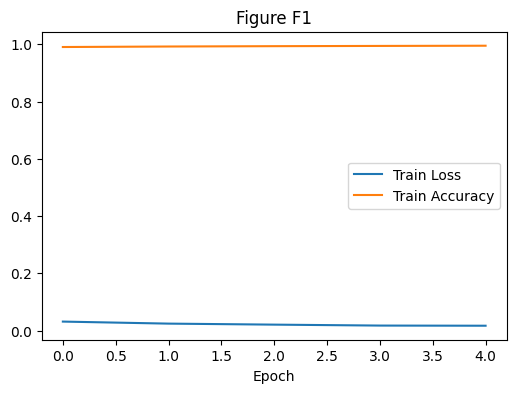

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(train_accuracy, label='Train Accuracy')
plt.xlabel('Epoch')
# plt.ylabel('Value')
plt.title('Figure F1')
plt.legend()
plt.show()

### Table T1

| Epoch | Train Loss | Train Acc | Test Acc |
|-------|------------|-----------|----------|
|1|0.0317|0.9902|0.8764|
|2|0.0246|0.9920|0.8895|
|3|0.0211|0.9932|0.8765|
|4|0.0178|0.9940|0.8791|
|5|0.0173|0.9947|0.8740|
